# Imports

In [1557]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [1612]:
space = pd.read_csv('/content/SpaceTitanic.csv')
space_test = pd.read_csv('/content/SpaceTitanicTest.csv')
combined = [space, space_test]

# Data Discovery

In [1559]:
space.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [1560]:
print("Data features are:\n")
print(space.columns.values)

Data features are:

['PassengerId' 'HomePlanet' 'CryoSleep' 'Cabin' 'Destination' 'Age' 'VIP'
 'RoomService' 'FoodCourt' 'ShoppingMall' 'Spa' 'VRDeck' 'Name'
 'Transported']


### Discovering the features types:

In [1561]:
print(space.info())
print('\n','='*80 , '\n')
print(space.describe())
print('\n','='*80 , '\n')
print(space.describe(include=['O']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000

**Results**
- 75% of passengers are younger than 38
- RoomService, FoodCourt, ShoppingMall, Spa and VRDeck are all heavily skewed with outliers
- There are only 199 VIPS (~ 2%)

**Insights**
- Skewness means we can't replace missing values with average

### Discovering the missing values:

In [1562]:
print("Data missing values:\n")
print(space.isnull().sum())
print('\n','_'*20 , '\n')
print("Data missing values %:\n")
print(round(space.isnull().sum()/8693, 3))

Data missing values:

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

 ____________________ 

Data missing values %:

PassengerId     0.000
HomePlanet      0.023
CryoSleep       0.025
Cabin           0.023
Destination     0.021
Age             0.021
VIP             0.023
RoomService     0.021
FoodCourt       0.021
ShoppingMall    0.024
Spa             0.021
VRDeck          0.022
Name            0.023
Transported     0.000
dtype: float64


All features have less than 3% missing values so data is quite good. Will discover correlations to act appropriately according to missing values.

# Exploratory Data Analysis (EDA)

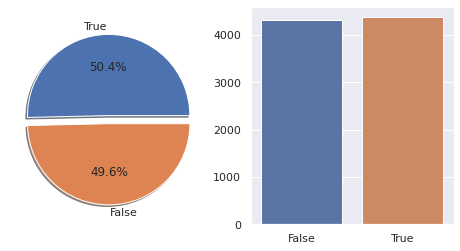

In [1563]:
# ===================================================================
# Transported count
# ===================================================================
f,ax=plt.subplots(1,2,figsize=(8,4))
space['Transported'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_ylabel('')
sns.countplot(x = space['Transported'], ax = ax[1])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
plt.show()

In [1564]:
def bar_plot(feature1, feature):
    plt.figure(figsize = (6,4))
    sns.barplot(data = space , x = feature , y = feature1).set_title(f"{feature} Vs {feature1}")
    plt.show()
def table(feature1, feature):
    return space[[feature, feature1]].groupby([feature], as_index=False).mean().sort_values(by=feature1, ascending=False).style.background_gradient(low=0.75,high=1)
def hist_plot(feature1, feature):
    plt.figure(figsize = (6,4))
    sns.histplot(data = space , x = feature , hue = feature1,binwidth=5,palette = sns.color_palette(["yellow" , "green"]) ,multiple = "stack" ).set_title(f"{feature} Vs {feature1}")
    plt.show()

**Home Planet Vs Transported**

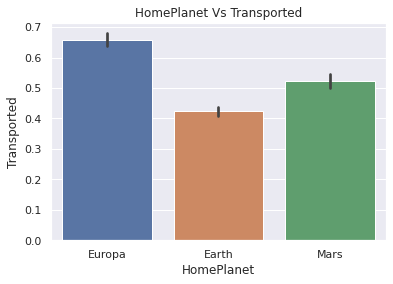

In [1565]:
bar_plot('Transported','HomePlanet')

In [1566]:
table('Transported','HomePlanet')

,HomePlanet,Transported
1,Europa,0.658846
2,Mars,0.523024
0,Earth,0.423946


**Cryo Sleep Vs Transported**

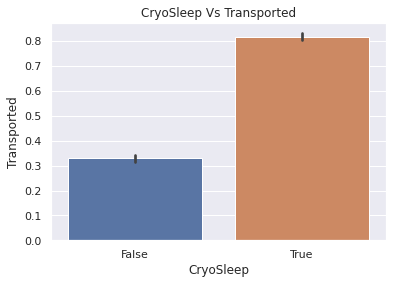

In [1567]:
bar_plot('Transported','CryoSleep')

In [1568]:
table('CryoSleep', 'VIP')

,VIP,CryoSleep
0,False,0.363805
1,True,0.107143


In [1569]:
table('Transported','CryoSleep')

,CryoSleep,Transported
1,True,0.817583
0,False,0.328921


**Cabin**

Cabin is formatted deck/num/side, the number is just the number passenger but if we can split deck and side into two new features may be useful.

In [1613]:
for dataset in combined:
  Deck = [cabin.split('/')[0] for cabin in dataset.Cabin.fillna('NA/NA/NA')]
  Side = [cabin.split('/')[2] for cabin in dataset.Cabin.fillna('NA/NA/NA')]
  dataset['Deck'] = Deck
  dataset['Side'] = Side

In [1571]:
bar_plot('Transported','Deck')

In [1572]:
bar_plot('Transported','Side')

**Destination Vs Transported**

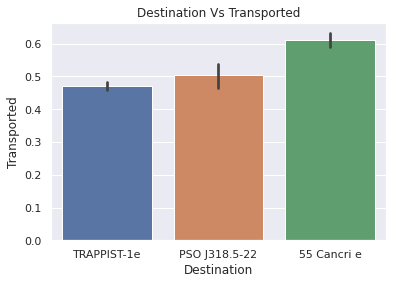

In [1573]:
bar_plot('Transported','Destination')

In [1574]:
table('Transported','Destination')

,Destination,Transported
0,55 Cancri e,0.610000
1,PSO J318.5-22,0.503769
2,TRAPPIST-1e,0.471175


**VIP Vs Transported**

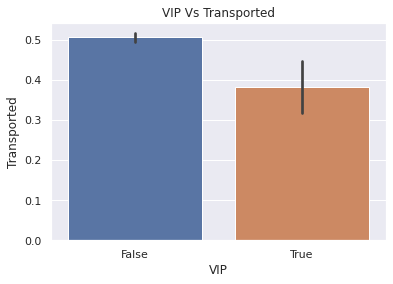

In [1575]:
bar_plot('Transported','VIP')

In [1576]:
table('Transported','VIP')

,VIP,Transported
0,False,0.506332
1,True,0.381910


**Age Vs Transported**

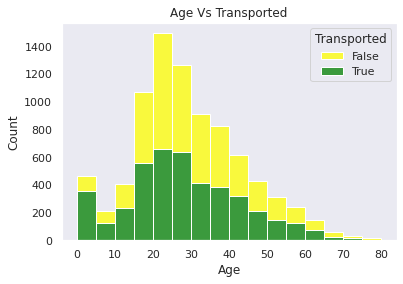

In [1577]:
sns.set_style("dark")
hist_plot('Transported',"Age")

- Ages 0-10 most likely to be transported
- Most passengers aged 14-40 years old
- Age band of 5 years good length

In [1578]:
print(space.columns.values)

['PassengerId' 'HomePlanet' 'CryoSleep' 'Cabin' 'Destination' 'Age' 'VIP'
 'RoomService' 'FoodCourt' 'ShoppingMall' 'Spa' 'VRDeck' 'Name'
 'Transported']


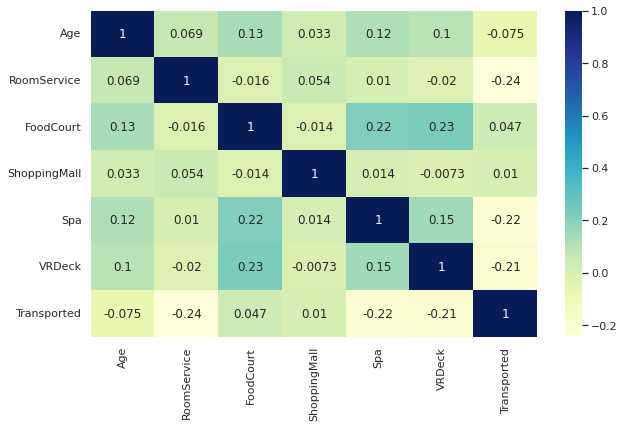

In [1579]:
sns.set(rc = {'figure.figsize':(10,6)})
sns.heatmap(space.corr(), annot = True, fmt='.2g',cmap= 'YlGnBu')

- FoodCourt, Spa and VRDeck correlated
- Room Service, Spa and VRDeck negatively correlated with transported

# Wrangling Data

Will be combing the training and test data so that we transform them together

### Drop useless features

In [1614]:
for dataset in combined:
  dataset.drop(columns = ['PassengerId', 'Cabin', 'Name'] , inplace = True)

### Filling Missing Values and Converting Categorical Features to Numerical

- Could Remove missing values
- Could Impute missing values by using the most common value or by prediction

For coverting, will be using Ordinal when I think there is a ranking in the categorical features, such as for Home Planet 0 would be Earth as it least correlates to Transported and Europa would be 2 as it most does.

*NOTE: Does not allow to alter all features in one for dataset in combined loop, as once we change a dataset the loop is still altering the original one*

In [1615]:
def FillNA_Cat(dataset, feature):
  dataset[feature].fillna(dataset[feature].value_counts().idxmax(), inplace=True)

def FillNA_Num(dataset, feature):
  dataset[feature].fillna(dataset[feature].median(), inplace=True)


for dataset in combined:
  # HomePlanet
  FillNA_Cat(dataset, 'HomePlanet')
  dataset['HomePlanet'] = dataset['HomePlanet'].dropna().map({'Earth':0, 'Mars':1, 'Europa':2}).astype(int)

for dataset in combined:
  #Destination
  FillNA_Cat(dataset, 'Destination')
  dataset['Destination'] = dataset['Destination'].map({'TRAPPIST-1e':0, 'PSO J318.5-22':1, '55 Cancri e':2}).astype(int)

for dataset in combined:
  #VIP
  dataset['VIP'].fillna(dataset['CryoSleep'], inplace=True) #VIP and CryoSleep seem highly correlated
  FillNA_Cat(dataset, 'VIP')
  dataset['VIP'] = dataset['VIP'].map({False:0, True:1}).astype(int)

for dataset in combined:
#CryoSleep
  dataset['CryoSleep'].fillna(dataset['VIP'], inplace=True) #VIP and CryoSleep seem highly correlated, CryoSleep very important for determining Transported
  FillNA_Cat(dataset, 'CryoSleep') #Incase of any values NA for both columns
  dataset['CryoSleep'] = dataset['CryoSleep'].dropna().map({False:0, True:1}).astype(int)

#Cabin
for dataset in combined:
  dataset.Deck = dataset.Deck.replace('NA', dataset.Deck.value_counts().idxmax())

space = space.join(pd.get_dummies(space.Deck, prefix = 'Deck'))
space = space.drop('Deck', axis = 1)
space_test = space_test.join(pd.get_dummies(space_test.Deck, prefix = 'Deck'))
space_test = space_test.drop('Deck', axis = 1)

combined = [space, space_test]

for dataset in combined:
  dataset.Side = dataset.Side.replace('NA', dataset.Side.value_counts().idxmax())
  dataset['Side'] = dataset['Side'].map({'P':0, 'S':1})

#Age
for dataset in combined:
  FillNA_Num(dataset, 'Age')

for dataset in combined:
#RoomService
  FillNA_Num(dataset, 'RoomService')

for dataset in combined:
#FoodCourt
  FillNA_Num(dataset, 'FoodCourt')

for dataset in combined:
#ShoppingMall
  FillNA_Num(dataset, 'ShoppingMall')

for dataset in combined:
#Spa
  FillNA_Num(dataset, 'Spa')

#VRDeck
for dataset in combined:
  FillNA_Num(dataset, 'VRDeck')

In [1616]:
space['Transported'] = space['Transported'].map({False:0, True:1}).astype(int)

**Final Checks**

In [ ]:
print("Data missing values:\n")
print(space.isnull().sum())
print('\n','_'*40 , '\n')
print(space.info())

In [ ]:
space.head()

# Sklearn Modelling

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(space, test_size=0.2)
X_train = train.drop(['Transported'],axis=1)
Y_train = train['Transported']

In [ ]:
kfold = StratifiedKFold(n_splits=4)

In [ ]:
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["SVC","DecisionTree","AdaBoost","RandomForest",
                                    "ExtraTrees","GradientBoosting","MultipleLayerPerceptron",
                                    "KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [ ]:
# Gradient boosting tuning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [300, 600],
              'learning_rate': [0.5, 0.1],
              'max_depth': [8, 16],
              'min_samples_leaf': [50, 100],
              'max_features': [0.1, 0.05] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 2)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

In [1597]:
gsGBC.best_params_

{'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 16,
 'max_features': 0.05,
 'min_samples_leaf': 100,
 'n_estimators': 600}

In [1598]:
gsGBC.best_score_

0.8032792512660544

# TensorFlow Modelling

In [ ]:
from sklearn.model_selection import train_test_split

full_train, test = train_test_split(space, test_size=0.2)
train, valid = train_test_split(full_train, test_size=0.2)
X_train = train.drop(['Transported'],axis=1)
y_train = train['Transported']
X_valid = valid.drop(['Transported'],axis=1)
y_valid = valid['Transported']

In [ ]:
X_train_deep = X_train.copy()
y_train_deep = y_train.copy()
X_valid_deep = X_valid.copy()
y_valid_deep = y_valid.copy()
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train_deep)

In [ ]:
normalizer(X_train_deep.iloc[:3])

In [ ]:
def build_model(n_hidden=2, n_neurons=30, learning_rate=0.1):
  model = keras.Sequential([normalizer])
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation='relu'))
  model.add(keras.layers.Dense(1))
  optimizer = keras.optimizers.SGD(learning_rate)
  model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

In [ ]:
model = keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
 "n_hidden": [0, 1, 2, 3],
 "n_neurons": np.arange(1, 100),
 "learning_rate": (0.1, 0.05),
}
rnd_search_cv = RandomizedSearchCV(model, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train_deep, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
rnd_search_cv.best_params_

In [1596]:
rnd_search_cv.best_score_

0.796887735525767

# Conclusions

Seems the quality of my data and how I handled it has bottle necked me at 80% accuracy.

In [1620]:
gsGBC.predict(space_test).astype(bool)

array([ True, False,  True, ...,  True,  True,  True])

In [1621]:
from numpy import copy
space_test2 = pd.read_csv('/content/SpaceTitanicTest.csv')

test_Transported = pd.Series(gsGBC.predict(space_test).astype(bool), name="Transported")

results = pd.concat([space_test2.PassengerId,test_Transported],axis=1)

results.to_csv("SpaceTitanicResults.csv",index=False)